<b><u>The following program will work out the overall and thickness local to antimcirobial for a simulation</u></b>. 

The steps to calculate local thickness are as follows:
 <ul>
  <li>Find lipids on the top layer within 6 angstrom of protein</li>
  <li>Find lipids within 6 angstrom of the above lipids</li>
  <li>Subtract the average z position of the two groups </li>
</ul> 


The overall thickness is calculated by taking the average z position of the top leaflet and the bottom leaflet. 


<i>To do: 

Output a lipid bilayer with the thickness score attached as a b-factor.</i>

In [3]:
import MDAnalysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import MDAnalysis.analysis.hbonds

In [9]:
! ls /volumes/external/antiseptic_simulations/octenidine_PEPG



octenidine_PEPG traj_comp.xtc


In [238]:
### Number of peptides ####
pepnum =4 
##gromacs configuration file###
gro_file = '/volumes/external/antiseptic_simulations/octenidine_PEPG/confout.gro'
##compressed trajectory file###
trajectory_file = '/volumes/external/antiseptic_simulations/octenidine_PEPG/traj_comp.xtc'
u = MDAnalysis.Universe('%s'%gro_file, '%s'%trajectory_file)
##### Sim start and sim end time in ns
start = 0 
end = 300
#### Single letter sequence #####
sequence = 'LLGDFFRKSKEKIGKEFKRIVQRIKDFLRNLVPRTES'
resnum = len(sequence) 

In [239]:
#use mdanalysis leaflet finder
from MDAnalysis.analysis import leaflet
L = leaflet.LeafletFinder(u, 'name P')

In [240]:
top_segment = u.add_Segment(segid='top_layer')
top_segment.atoms
top_atoms = L.groups(1).atoms
top_atoms.residues.segments = top_segment

In [234]:
L.groups(1).atoms

<AtomGroup with 256 atoms>

In [235]:
bottom_segment = u.add_Segment(segid='bottom_layer')
bottom_segment.atoms
bottom_atoms = L.groups(0).atoms
bottom_atoms.residues.segments = bottom_segment

In [249]:
list(u.select_atoms('segid top_layer and around 6 resname octen'))

[<Residue POPE, 1>]

In [ ]:
for ts in u.trajectory[0::100]:
    print(len(u.select_atoms('segid bottomlayer and around 4 resname octen')))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [199]:
##loop through trajectory 
thickness =[]
for ts in u.trajectory[0::50]: 
    ##create a segment that updates with time step - Is this needed in loop?
    top_protein_segment = u.add_Segment(segid='top_layer_protein')
    top_protein_segment.atoms
    top_protein_atoms = u.select_atoms("name P and segid top_layer and same residue as around 6 resname octen ")
    top_protein_atoms.residues.segments = top_protein_segment
    ##select atoms on top layer near protein, calculate mean z position
    top = np.mean(u.select_atoms('name P and segid top_layer_protein').positions[:,[2]])
    ##selection atoms on bottom layer, near top layer for distance calculation
    bottom = np.mean(u.select_atoms('name P and segid bottom_layer and same residue as around 6 segid top_layer_protein').positions[:,[2]])
    local_thickness = top-bottom
    ##overall thickness
    whole_top = np.mean(u.select_atoms('name P and segid top_layer').positions[:,[2]])
    whole_bottom = np.mean(u.select_atoms('name P and segid bottom_layer').positions[:,[2]])   
    whole_thickness = whole_top-whole_bottom                       
    thickness.append([u.trajectory.time,local_thickness,whole_thickness])

/Users/philipferguson/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/philipferguson/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [128]:
thickness

[[0.0, nan, nan],
 [1000.0, nan, nan],
 [2000.0, nan, nan],
 [3000.0, nan, nan],
 [4000.0, nan, nan],
 [5000.0, nan, nan],
 [6000.0, nan, nan],
 [7000.0, nan, nan],
 [8000.0, nan, nan],
 [9000.0, nan, nan],
 [10000.0, nan, nan],
 [11000.0, nan, nan],
 [12000.0, nan, nan],
 [13000.0, nan, nan],
 [14000.0, nan, nan],
 [15000.0, nan, nan],
 [16000.0, nan, nan],
 [17000.0, nan, nan],
 [18000.0, nan, nan],
 [19000.0, nan, nan],
 [20000.0, nan, nan],
 [21000.0, nan, nan],
 [22000.0, nan, nan],
 [23000.0, nan, nan],
 [24000.0, nan, nan],
 [25000.0, nan, nan],
 [26000.0, nan, nan],
 [27000.0, nan, nan],
 [28000.0, nan, nan],
 [29000.0, nan, nan],
 [30000.0, nan, nan],
 [31000.0, nan, nan],
 [32000.0, nan, nan],
 [33000.0, nan, nan],
 [34000.0, nan, nan],
 [35000.0, nan, nan],
 [36000.0, nan, nan],
 [37000.0, nan, nan],
 [38000.0, nan, nan],
 [39000.0, nan, nan],
 [40000.0, nan, nan],
 [41000.0, nan, nan],
 [42000.0, nan, nan],
 [43000.0, nan, nan],
 [44000.0, nan, nan],
 [45000.0, nan, nan],
 

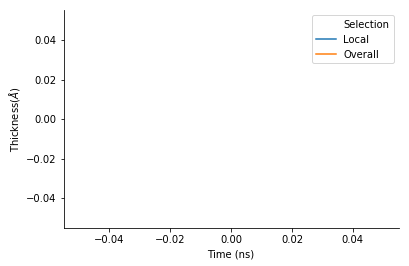

In [9]:
##load columns into data frame, rename
df_thick = pd.DataFrame(thickness)
df_thick.rename(columns={ df_thick.columns[0]: "Time (ns)", df_thick.columns[1]: "Local",
                   df_thick.columns[2]: "Overall" }, inplace = True)
##melt, set variabl for hue
df_thick = df_thick.melt(id_vars='Time (ns)',var_name='Selection',value_name='Thickness')
df_thick['Time (ns)'] = df_thick['Time (ns)']/1000
##filter data, similar to moving average
from scipy.signal import savgol_filter
df_thick['Thickness'] = savgol_filter(df_thick['Thickness'],31,2)
##plot 
sns.lineplot(data=df_thick,x='Time (ns)',y='Thickness',hue='Selection')
sns.despine()
plt.xlabel("Time (ns)")
plt.ylabel(r'Thickness($\AA$)')
plt.savefig('Membrane_thickness.png',dpi=300,bbox_inches="tight")

<b><u>The following program will work out the overall and Area per lipid local to antimcirobial for a simulation</u></b>. 

The steps to calculate local Area_per_lipid are as follows:
 <ul>
  <li>Find coordinates for centre of mass of protein</li>
  <li>Calculate number of lipids within a distance. Distance is the external radius of a sphere</li>
  <li>Calculate area of circle from radius </li>
  <li>Divide area by number of lipids within to give area per lipid </li>
  <li>Average each local area per lipid for each peptide </li>
</ul> 



<i>To do: 

<ul>
    Valid results.
Consider effective way to avoid artifacts of peptide not being bound to membrane. <ul>
</i>

In [19]:
##This will create an area around the centre of mass of 20 angstrom and identify lipids within in it.
##it will then divde the area by the total number of lipids identified to give the area per lipid (headgroup)
## results will be averaged between peptides 
Area_per_lipid=[]
for ts in u.trajectory[1000::100]:
    peptide = []
    for i in range(0,pepnum):
        end_point=(0+1)*resnum
        start_point = (0*resnum)+1
        selection = "resid %s"%start_point + "-%s"%end_point
        x = str(u.select_atoms('%s'%selection).center_of_mass()[0])
        y = str(u.select_atoms(' %s'%selection).center_of_mass()[1])
        z = str(u.select_atoms(' %s'%selection).center_of_mass()[2])
        #The final part of this string can be adjusted
        co_ords = "%s "%x + "%s " %y + "%s"%z + " 25"
        A = np.pi*np.square(25)
        n = int((len(u.select_atoms('name P and same residue as point %s'%co_ords).positions)))
        APL = A/n
        peptide.append(APL)
    #take box vectors, use this to work out overall area per lipid. 
    whole_area=(np.square(u.dimensions[0])/256)
    Area_per_lipid.append([u.trajectory.time,np.mean(peptide),whole_area])

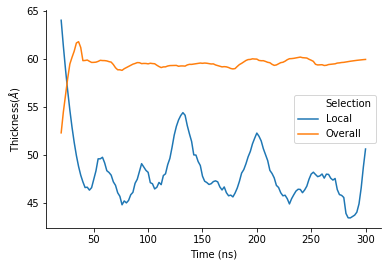

In [29]:
##load columns into data frame, rename
df_apl = pd.DataFrame(Area_per_lipid)
df_apl.rename(columns={ df_apl.columns[0]: "Time (ns)", df_apl.columns[1]: "Local",
                   df_apl.columns[2]: "Overall" }, inplace = True)
##melt, set variabl for hue
df_apl = df_apl.melt(id_vars='Time (ns)',var_name='Selection',value_name='Thickness')
df_apl['Time (ns)'] = df_apl['Time (ns)']/1000
##filter data, similar to moving average
from scipy.signal import savgol_filter
df_apl['Thickness'] = savgol_filter(df_apl['Thickness'],21,2)
##plot 
sns.lineplot(data=df_apl,x='Time (ns)',y='Thickness',hue='Selection')
sns.despine()
plt.xlabel("Time (ns)")
plt.ylabel(r'Thickness($\AA$)')
plt.savefig('Area_per_lipid.png',dpi=300,bbox_inches="tight")

<u><b> The following cells will clculate the ratio of POPE to POPG lipids within 6 angstrom of protein. </b></u>

In [92]:
###calculate lipid ratio
lipid_ratio=[]
for ts in u.trajectory[0::50]: 
    POPE_near=len(list(u.select_atoms('resname POPE and same residue as around 6 protein').residues))
    POPG_near=len(list(u.select_atoms('resname POPG and same residue as around 6 protein').residues))
    if int(POPG_near) < 1 or int(POPE_near) < 1:
        Ratio=3
    else:
        Ratio=POPE_near/POPG_near
    lipid_ratio.append([u.trajectory.time,Ratio])
    

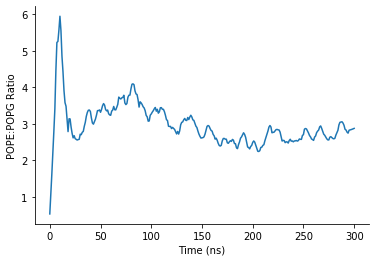

In [104]:
#plot lipid ratio
df_ratio = pd.DataFrame(lipid_ratio)
df_ratio.rename(columns={ df_ratio.columns[0]: "Time (ns)", df_ratio.columns[1]: "POPE:POPG Ratio" }, 
                inplace = True)
df_ratio['POPE:POPG Ratio'] = savgol_filter(df_ratio['POPE:POPG Ratio'],11,2)
sns.lineplot(data=df_ratio,x=df_ratio['Time (ns)']/1000,y='POPE:POPG Ratio')
sns.despine()
plt.savefig('Ratio.png',dpi=300,bbox_inches="tight")

<u><b> Can something be written for lipid order parameteR????</b></u>

In [228]:

import numpy as np
from MDAnalysis import *

universe = Universe("LL37x4.part0015.gro")

tail_carbons = np.arange(2, 15)

skip = 5
order_param = np.zeros(len(tail_carbons))

for i, carbon in enumerate(tail_carbons):
    selection = "resname DMPC and ( name C2{0:d} or name H{1:d}R or name H{2:d}S or name C3{3:d} or name H{4:d}X or name H{5:d}Y )".format(* \
                ((carbon,) * 6))
    group = universe.select_atoms(selection)

    data = universe.timeseries(group, format="afc", skip=skip)

AttributeError: No attribute "timeseries".

In [ ]:
POPE["B"] = ["Long" if ele  == "BULL" else "Short" for ele in df["A"]]